<a href="https://colab.research.google.com/github/NARAYANAREDDY37/Santander-Customer-Transaction-Prediction/blob/main/Customer_transaction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing kaggle's data to colab

In [ ]:
#to access kaggle datasets 
!pip install kaggle

In [ ]:
# Install kaggle packages 
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 5.3MB 7.0MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 143kB 24.5MB/s 
     |████████████████████████████████| 112kB 38.4MB/s 


In [ ]:
#colab file access
from google.colab import files

In [ ]:
#uploading kaggle.json file
upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#retrieving the uploaded files and printinf the results
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c santander-customer-transaction-prediction

 98% 122M/125M [00:10<00:00, 17.7MB/s]
100% 125M/125M [00:10<00:00, 12.3MB/s]
 90% 113M/125M [00:09<00:01, 10.6MB/s]
100% 125M/125M [00:09<00:00, 13.1MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 30.9MB/s]


Unzipping the data

In [ ]:
! unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
! unzip /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [ ]:
! unzip /content/sample_submission.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
# Import necessary libraries

import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')


In [ ]:
# Reading the data

train = pd.read_csv('/content/train.csv')
test  = pd.read_csv('/content/test.csv')

In [ ]:
#printing the shape of the data

print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (200000, 202)
test shape: (200000, 201)


In [ ]:
#viewing the training and testing data
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Exploring the data

In [ ]:
# Finding missing values in train and test data

def func(df):
    a = df.isnull().sum()
    b = df.count()
    c = (a/b) * 100
    d = pd.DataFrame(a, columns = ['Missingvalue%'])
    return d['Missingvalue%'].sum()

In [ ]:
print('missing values in train data:', func(train))
print('missing values in test data:', func(test))

missing values in train data: 0
missing values in test data: 0


obeservations: There are no missing values in the data

In [ ]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [ ]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

In [ ]:
# let's visualize training and testing data

def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

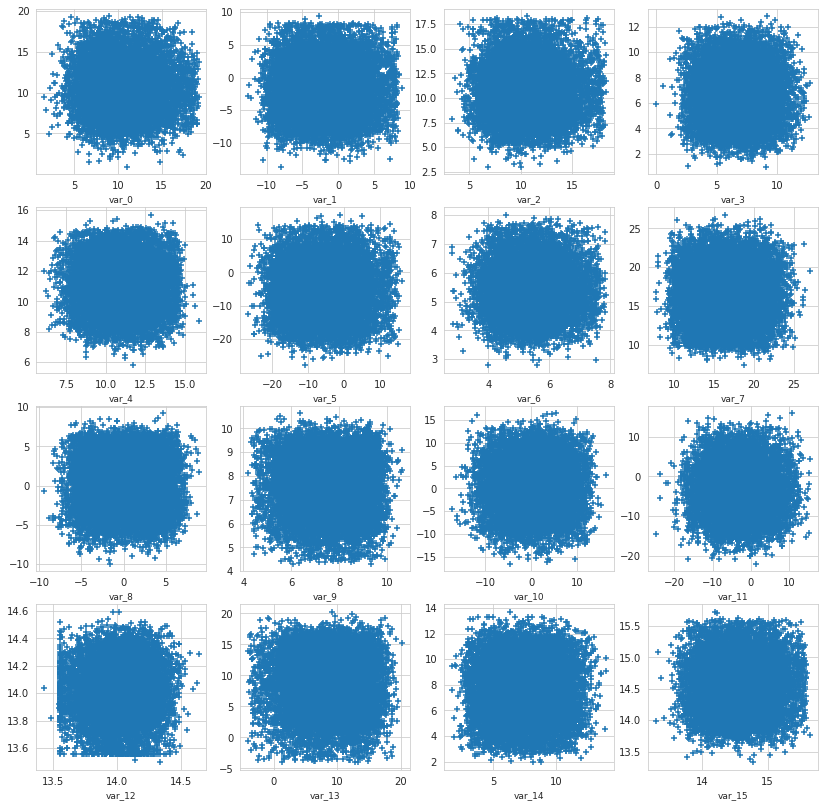

In [ ]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train[::20],test[::20], features)

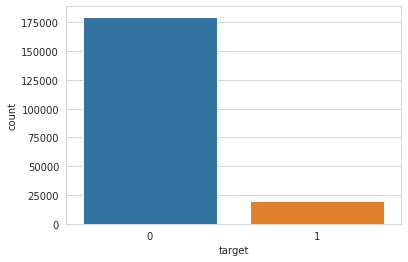

In [ ]:
#let's see the distribution of target column
sns.countplot(train.target)

In [ ]:
#Total percentage of distribution of 1 in target column

print('% of 1 in train data:', (train.target.value_counts()[1]/train.shape[0]) * 100)

% of 1 in train data: 10.049


Observation: It seems only 10.049 percentage of 1 as value in target column. so the target column is highly imbalanced

In [ ]:
#checking the correlation

correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations.head(10)

,level_0,level_1,0
0,var_1,var_3,0.000010
1,var_3,var_1,0.000010
2,var_15,var_0,0.000043
3,var_0,var_15,0.000043
4,var_6,var_4,0.000049
5,var_4,var_6,0.000049
6,var_13,var_15,0.000109
7,var_15,var_13,0.000109
8,var_13,var_9,0.000119
9,var_9,var_13,0.000119


In [ ]:
correlations.tail(10)

,level_0,level_1,0
246,var_8,var_8,1.0
247,var_7,var_7,1.0
248,var_6,var_6,1.0
249,var_5,var_5,1.0
250,var_4,var_4,1.0
251,var_3,var_3,1.0
252,var_2,var_2,1.0
253,var_1,var_1,1.0
254,var_14,var_14,1.0
255,var_15,var_15,1.0


Observation: The correlation between X variables is very low

In [ ]:
#checking duplicate values

features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [ ]:
unique_max_train

[['var_0', 11, 10.6829],
 ['var_1', 10, -2.4313],
 ['var_2', 12, 9.1497],
 ['var_3', 15, 6.8029],
 ['var_4', 15, 10.8911],
 ['var_5', 7, -7.5212],
 ['var_6', 22, 5.1153],
 ['var_7', 11, 18.9966],
 ['var_8', 11, -2.2274],
 ['var_9', 18, 7.2048],
 ['var_10', 9, 0.8671],
 ['var_11', 8, -6.5005],
 ['var_12', 203, 13.5545],
 ['var_13', 9, 12.344000000000001],
 ['var_14', 12, 8.9383],
 ['var_15', 34, 14.6482],
 ['var_16', 14, 10.743],
 ['var_17', 8, -8.2807],
 ['var_18', 9, 10.2625],
 ['var_19', 7, 15.5568],
 ['var_20', 10, 8.5437],
 ['var_21', 10, 13.9733],
 ['var_22', 11, 2.6718],
 ['var_23', 32, 2.9116],
 ['var_24', 10, 8.1986],
 ['var_25', 41, 13.6723],
 ['var_26', 9, 0.7814],
 ['var_27', 15, -0.5237],
 ['var_28', 24, 5.3723],
 ['var_29', 12, 3.7681],
 ['var_30', 6, -13.3689],
 ['var_31', 14, 10.1993],
 ['var_32', 13, -1.0086],
 ['var_33', 13, 11.1284],
 ['var_34', 30, 11.1229],
 ['var_35', 10, 2.0915],
 ['var_36', 13, 2.5371],
 ['var_37', 13, 4.9476],
 ['var_38', 9, 10.8943],
 ['var_39'

In [ ]:
unique_max_test

[['var_0', 20, 9.5368],
 ['var_1', 18, -3.66],
 ['var_2', 21, 10.3544],
 ['var_3', 22, 8.5594],
 ['var_4', 24, 10.8383],
 ['var_5', 16, -11.9289],
 ['var_6', 33, 5.797999999999999],
 ['var_7', 18, 12.1081],
 ['var_8', 21, -0.0851],
 ['var_9', 28, 8.6081],
 ['var_10', 17, 4.9549],
 ['var_11', 18, 0.2551],
 ['var_12', 188, 13.5546],
 ['var_13', 16, 7.9855],
 ['var_14', 20, 8.262],
 ['var_15', 47, 14.6942],
 ['var_16', 21, 10.0245],
 ['var_17', 14, -8.4267],
 ['var_18', 16, 7.2567],
 ['var_19', 16, 9.0209],
 ['var_20', 17, 15.3813],
 ['var_21', 14, 16.8568],
 ['var_22', 18, 6.4599],
 ['var_23', 50, 2.9221],
 ['var_24', 18, 10.0177],
 ['var_25', 60, 13.5965],
 ['var_26', 16, -4.2819],
 ['var_27', 24, 0.4143],
 ['var_28', 32, 5.9894],
 ['var_29', 22, 6.8072],
 ['var_30', 15, -6.6589],
 ['var_31', 21, 10.0365],
 ['var_32', 24, -0.1575],
 ['var_33', 17, 18.7479],
 ['var_34', 39, 11.2193],
 ['var_35', 18, 1.4012],
 ['var_36', 24, 2.1027],
 ['var_37', 26, 7.7094],
 ['var_38', 22, 9.6369],
 ['va

In [ ]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [ ]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


In [ ]:
#aggregated values of the features

idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [ ]:
#for training data
train[train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [ ]:
test[test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [ ]:
#Distributio of new fearured values

def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()

<Figure size 432x288 with 0 Axes>

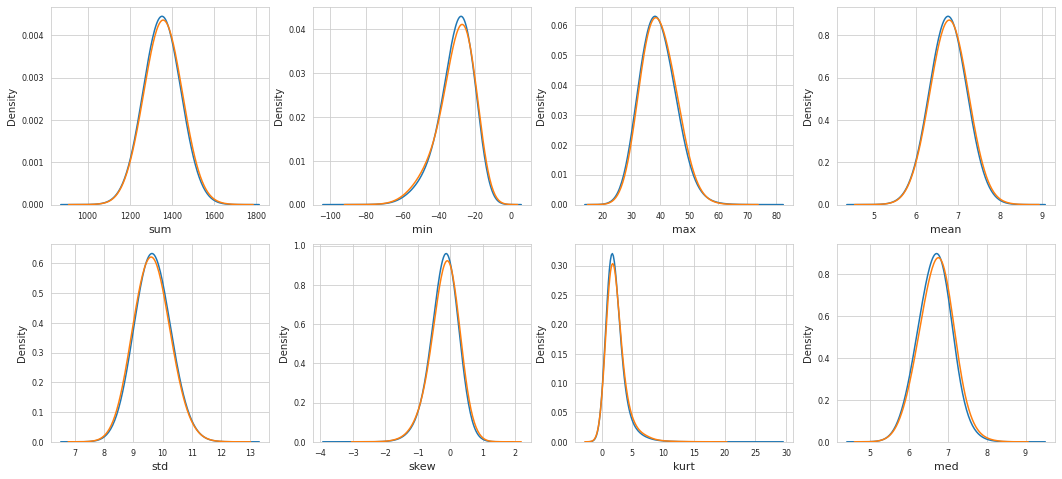

In [ ]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Distribution of new features values for train and test

<Figure size 432x288 with 0 Axes>

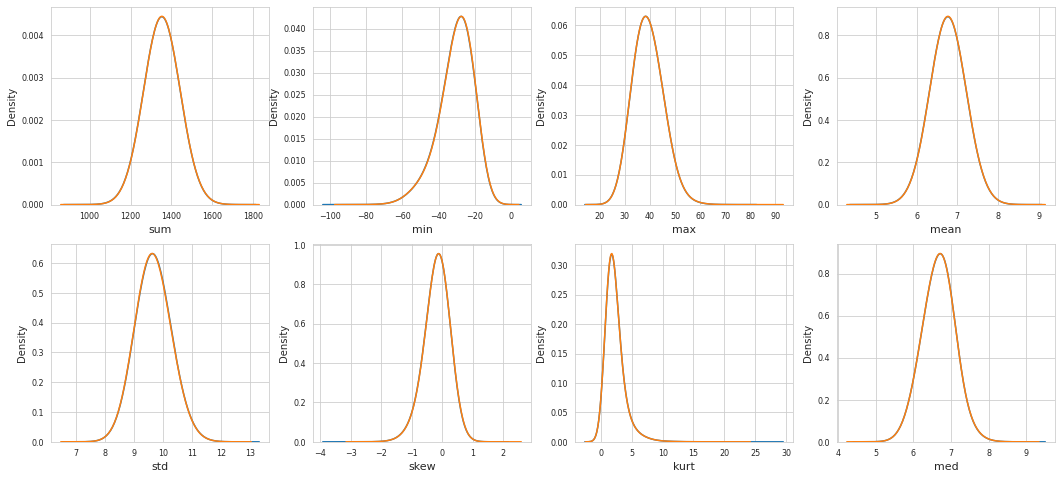

In [ ]:
plot_new_feature_distribution(train, test, 'train', 'test', features)

In [ ]:
#Total number of columns in train and test data
print('Train and test columns: {} {}'.format(len(train.columns), len(test.columns)))

Train and test columns: 210 209


Building a model

In [ ]:
#Dropping ID and target column to seperate features and target column
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [ ]:
#Defining the hyperparameters grid for model

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [ ]:
#Running the model

folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900688	valid_1's auc: 0.881785
[2000]	training's auc: 0.911592	valid_1's auc: 0.888668
[3000]	training's auc: 0.919073	valid_1's auc: 0.892539
[4000]	training's auc: 0.92493	valid_1's auc: 0.895117
[5000]	training's auc: 0.929779	valid_1's auc: 0.896903
[6000]	training's auc: 0.934117	valid_1's auc: 0.897716
[7000]	training's auc: 0.938033	valid_1's auc: 0.8984
[8000]	training's auc: 0.941701	valid_1's auc: 0.898689
[9000]	training's auc: 0.94528	valid_1's auc: 0.899
[10000]	training's auc: 0.948639	valid_1's auc: 0.899159
[11000]	training's auc: 0.951854	valid_1's auc: 0.899314
[12000]	training's auc: 0.954937	valid_1's auc: 0.89954
[13000]	training's auc: 0.957916	valid_1's auc: 0.899413
[14000]	training's auc: 0.960689	valid_1's auc: 0.899371
Early stopping, best iteration is:
[11934]	training's auc: 0.954724	valid_1's auc: 0.899589
Fold 1
Training until validation scores don't improve fo

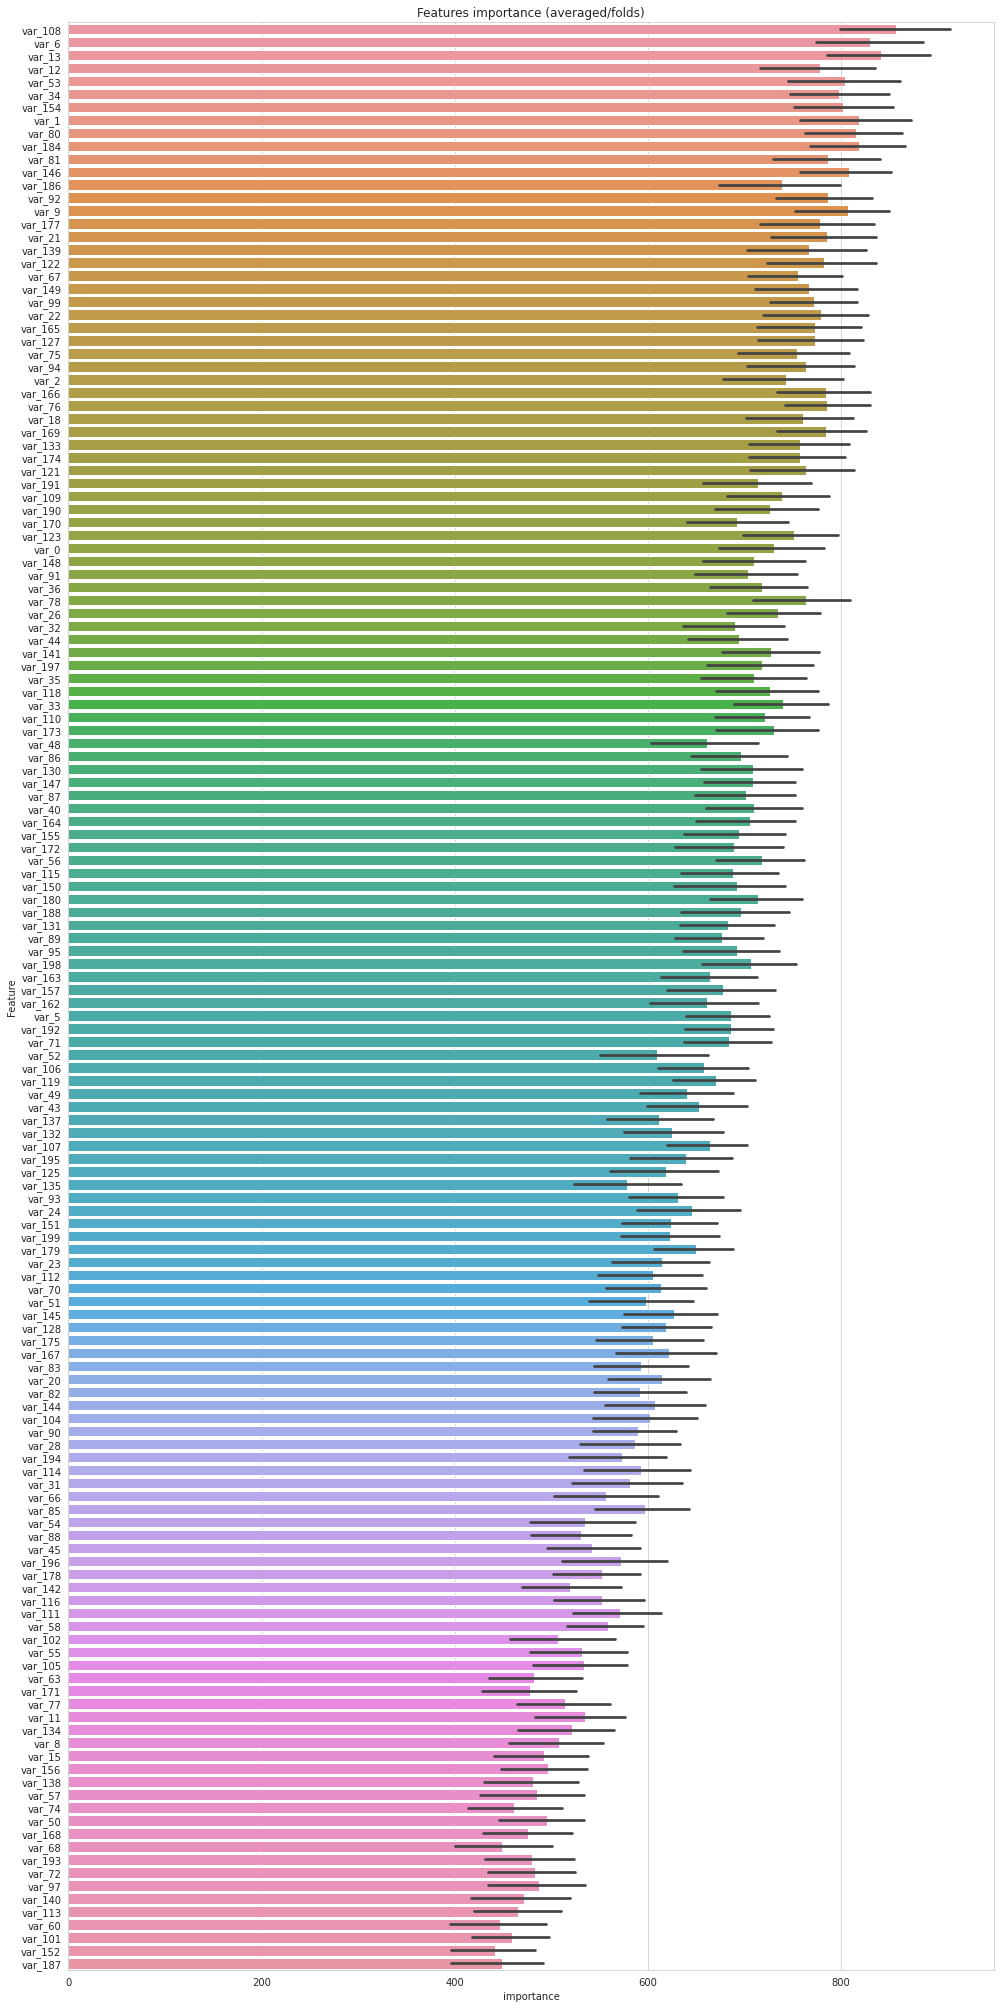

In [ ]:
#plotting the feature importance

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [ ]:
#predicting the results for test data

Prtd = pd.DataFrame({"ID_code":test["ID_code"].values})
Prtd["target"] = predictions

Prtd.to_csv("prtd.csv", index=False)